# Imports

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix, andrews_curves

from datetime import datetime
import random

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, hamming_loss, classification_report
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from collections import defaultdict

import numpy as np
import scipy.stats as st
import scipy
import scipy.io

from itertools import product

from skimage import io, transform

import PIL
from PIL import Image, ImageOps, ImageFilter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import pdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

import torchvision
from torchvision import transforms, utils, datasets, models

torch.set_printoptions(linewidth=120)

import re
import copy
import os

import math
import csv

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
from time import time, sleep
from IPython import get_ipython
from IPython.display import Audio, display, HTML
from ipywidgets import IntProgress

class Beeper:

    def __init__(self, threshold, **audio_kwargs):
        self.threshold = threshold
        self.start_time = None    # time in sec, or None
        self.audio = audio_kwargs

    def pre_execute(self):
        if not self.start_time:
            self.start_time = time()
            

    def post_execute(self):
        end_time = time()
        if self.start_time and end_time - self.start_time > self.threshold:
            audio = Audio(**self.audio, autoplay=True)
            display(audio)
            print((end_time - self.start_time)/60, " minutes.")
        self.start_time = None

beeper = Beeper(5, filename='beep-07.wav')

ipython = get_ipython()
ipython.events.register('pre_execute', beeper.pre_execute)
ipython.events.register('post_execute', beeper.post_execute)



# Class Definitions

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, 5)
        self.conv2 = nn.Conv2d(4, 8, 5)
        self.conv3 = nn.Conv2d(8, 16, 5)
        
        self.fc1 = nn.Linear(in_features =  9216, out_features = 2000)
        self.fc2 = nn.Linear(in_features = 2000, out_features = 200)
        self.out = nn.Linear(in_features = 200, out_features = 120)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, t):
        
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        #print("hc 1 before : ",t.shape)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print("hc 1 after : ",t.shape)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        #print("hc 2 before : ",t.shape)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print("hc 2 after : ",t.shape)
        
        # (3.5) hidden conv layer
        t = self.conv3(t)
        t = F.relu(t)
        #print("hc 3 before : ",t.shape)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print("hc 3 after : ",t.shape)

        # (4) hidden linear layer
        #[64, 8, 53, 53]
        t = t.view(-1, 9216)
        t = self.fc1(t)
        #print(t.shape)
        t = F.relu(t)
        #print(t.shape)
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        #print(t.shape)

        # (6) output layer
        t = self.out(t)
        t = self.softmax(t, dim=1)
        #print(t.shape)

        return t
        #x = F.relu(self.conv1(x))
        #return F.relu(self.conv2(x))
        #return x

In [4]:
class Network_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.conv2 = nn.Conv2d(4, 8, 3, padding = 3)
        self.conv3 = nn.Conv2d(8, 16, 3, padding = 3)
        
        self.conv4 = nn.Conv2d(in_channels = 16, out_channels = 2000, kernel_size = 30)
        self.do1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features = 2000, out_features = 200)
        self.do2 = nn.Dropout(0.5)
        self.out = nn.Linear(in_features = 200, out_features = 120)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, t):
        
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        #print("hc 1 before : ",t.shape)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print("hc 1 after : ",t.shape)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        #print("hc 2 before : ",t.shape)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print("hc 2 after : ",t.shape)
        
        # (3.5) hidden conv layer
        t = self.conv3(t)
        t = F.relu(t)
        #print("hc 3 before : ",t.shape)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        #print("hc 3 after : ",t.shape)
############################################################################
        # (4) hidden linear layer
        #[64, 8, 53, 53]
        t = self.conv4(t)
        t = t.view(-1, 2000)
        t = F.relu(t)


        
        #t = t.view(-1, 7056)
        #t = self.fc1(t)
        #print(t.shape)
        #t = F.relu(t)
        #print(t.shape)
############################################################################
        t = self.do1(t)
        #print(t.shape)


        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        #print(t.shape)
        
        t = self.do2(t)
        
        # (6) output layer
        t = self.out(t)
        t = self.softmax(t)
        #print(t.shape)

        return t
        #x = F.relu(self.conv1(x))
        #return F.relu(self.conv2(x))
        #return x

# Data

## Data Loading

In [5]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        #print("rescale sample is : ", sample)


        image = sample
        #print(image.size)

        h, w = image.size
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = image.resize((new_h, new_w))

        #img = transform.resize(image, (new_h, new_w))

        return img


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        #print("radomcrop sample is : ", sample)
        #print("radomcrop size is : ", sample.size)


        image = sample

        h, w = image.size
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        #print(left, top, top + new_h, left + new_w)
        

        image = image.crop([top, left, top + new_h, left + new_w])
        #print(image.size)
        #image.show()
        return image

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image)

In [6]:
def loader_one(path, batch_len):
    data_path = path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.Lambda(lambda x: BlurTransform(x, 0.5)),
            Rescale(256),
            RandomCrop(224),
            transforms.ToTensor(),
            transforms.RandomErasing(0.3),
        ])
    )
    
    dataset_size = len(train_dataset)
    print("dataset_size", dataset_size)
    indices = list(range(dataset_size))
    split = int(np.floor(0.15 * dataset_size))
    
    if True:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
    test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_len, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_len, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_len, sampler=test_sampler)
    
    return train_loader, val_loader, test_loader


def loader_two(path, batch_len):
    data_path = path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
            Rescale(256),
            RandomCrop(224),
            transforms.ToTensor(),
        ])
    )
    
    dataset_size = len(train_dataset)
    print("dataset_size", dataset_size)
    indices = list(range(dataset_size))
    split = int(np.floor(0.15 * dataset_size))
    
    if True:
        np.random.seed(42)
        np.random.shuffle(indices)

    train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)
    test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_len, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_len, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_len, sampler=test_sampler)
    
    return train_loader, val_loader, test_loader

def load_complete_dataset(path):
    data_path = path
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.Lambda(lambda x: BlurTransform(x, 0.5)),
            Rescale(256),
            RandomCrop(224),
            transforms.ToTensor(),
            transforms.RandomErasing(0.3),
        ])
    )
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = False)

    return train_loader

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

def BlurTransform(self, limit):
    thresh = random.uniform(0, 1)
    if(thresh < limit):
        image = self.filter(ImageFilter.BoxBlur(1))
        return image
    else : 
        return self

In [8]:
import h5py

class dataset_h5_train(torch.utils.data.Dataset):
    transform=torchvision.transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.Lambda(lambda x: BlurTransform(x, 0.5)),
            Rescale(256),
            RandomCrop(224),
            transforms.ToTensor(),
            transforms.RandomErasing(0.3),
    ])
    def __init__(self, in_file, transform=None):
        super(dataset_h5_train, self).__init__()

        self.file = h5py.File(in_file, 'r')
        self.transform = transform

    def __getitem__(self, index):
      x = self.file['X_train'][index, ...]
      y = self.file['Y_train'][index, ...]

      # Preprocessing each image
      if self.transform is not None:
          x = self.transform(x)
          x = torch.from_numpy(x) 
          y = torch.from_numpy(y)  

      x = torch.from_numpy(x).permute(2,0,1)
      #x = x.type(torch.FloatTensor)
      y = torch.from_numpy(y[0])      

      return (x, y), index
    def __len__(self):
        return self.file['X_train'].shape[0]

class dataset_h5_valid(torch.utils.data.Dataset):
    transform=torchvision.transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.Lambda(lambda x: BlurTransform(x, 0.5)),
            Rescale(256),
            RandomCrop(224),
            transforms.ToTensor(),
            transforms.RandomErasing(0.3),
    ])
    def __init__(self, in_file, transform=None):
        super(dataset_h5_valid, self).__init__()

        self.file = h5py.File(in_file, 'r')
        self.transform = transform

    def __getitem__(self, index):
      x = self.file['X_dev'][index, ...]
      y = self.file['Y_dev'][index, ...]

      # Preprocessing each image
      if self.transform is not None:
          x = self.transform(x)
          x = torch.from_numpy(x) 
          y = torch.from_numpy(y)
      x = torch.from_numpy(x).permute(2,0,1)
      y = torch.from_numpy(y[0])          

      return (x, y), index
    def __len__(self):
        return self.file['X_dev'].shape[0]

class dataset_h5_test(torch.utils.data.Dataset):
    transform = torchvision.transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.Lambda(lambda x: BlurTransform(x, 0.5)),
            Rescale(256),
            RandomCrop(224),
            transforms.ToTensor(),
            transforms.RandomErasing(0.3),
    ])

    def __init__(self, in_file, transform=None):
        super(dataset_h5_test, self).__init__()

        self.file = h5py.File(in_file, 'r')
        self.transform = transform

    def __getitem__(self, index):
      x = self.file['X_test'][index, ...]
      y = self.file['Y_test'][index, ...]

      # Preprocessing each image
      if self.transform is not None:
          x = self.transform(x)    
          print(type(x))   

      x = torch.from_numpy(x).permute(2,0,1)
      y = torch.from_numpy(y[0])        

      return (x, y), index
    def __len__(self):
        return self.file['X_test'].shape[0]

dataset_train = dataset_h5_train("./DataH5.hdf5")
dataset_valid = dataset_h5_valid("./DataH5.hdf5")
dataset_test = dataset_h5_test("./DataH5.hdf5")

dataloader_train = torch.utils.data.DataLoader(
  dataset_train, batch_size=32,
  drop_last=True, shuffle=True, num_workers=1)

dataloader_valid = torch.utils.data.DataLoader(
  dataset_valid, batch_size=32,
  drop_last=True, shuffle=True, num_workers=1)

dataloader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=32,
  drop_last=True, shuffle=True, num_workers=1)

In [166]:
dataset_torch = load_complete_dataset("./Images")
for i in range(10):
    print(dataset_torch.dataset[i][1])

0
0
0
0
0
0
0
0
0
0


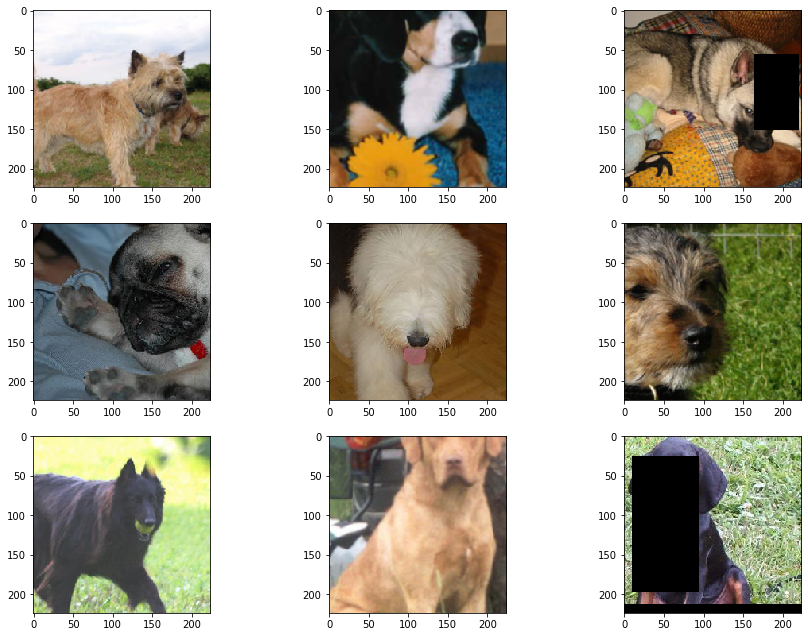

In [21]:
fig = plt.figure(figsize=(15, 15))

for i in range(9):
    ax = fig.add_subplot(4, 3, i+1)
    it = np.random.randint(20000)
    plt.imshow(  dataset_torch.dataset[it][0].permute(1, 2, 0)  )
    


labeled_data = []
for i in range(len(file_list["labels"])):
    if(i > 1):
        if(file_list["labels"][i][0] != file_list["labels"][i-1][0]): print(file_list["labels"][i+1][0])
    labeled_data.append((dataset_torch.dataset[i][0],file_list["labels"][i][0] - 1) )
    

## Dataset Creation

In [173]:
train_data, test_data = train_test_split(dataset_torch.dataset, train_size = 0.85, shuffle = True)

2.066345699628194  minutes.


In [174]:
train_len = np.int(np.floor(len(train_data)*0.15))
#train_len = np.int(np.floor((len(dataset_torch.dataset)*0.85)*0.15))

train_loader = torch.utils.data.DataLoader(train_data[train_len:],
                                           batch_size=64,
                                           num_workers=0,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(train_data[:train_len],
                                           batch_size=64,
                                           num_workers=0,
                                           shuffle=True)

#Rajouter Validation (voir quelle taille lui donner) 
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=64,
                                           num_workers=0,
                                           shuffle=True)

In [175]:
mini_train_loader = torch.utils.data.DataLoader(train_loader.dataset[:np.int(np.floor(len(train_loader.dataset)*0.10))],
                                           batch_size=16,
                                           num_workers=0,
                                           shuffle=True)
#Same here
mini_validation_loader = torch.utils.data.DataLoader(validation_loader.dataset[:np.int(np.floor(len(test_loader.dataset)*0.10))],
                                           batch_size=16,
                                           num_workers=0,
                                           shuffle=True)

mini_test_loader = torch.utils.data.DataLoader(test_loader.dataset[:np.int(np.floor(len(test_loader.dataset)*0.10))],
                                           batch_size=16,
                                           num_workers=0,
                                           shuffle=True)

In [221]:
# 4 different models
data_one = loader_one("./Images", 64)

data_two = loader_two("./Images", 64)

network_one = Network()

network_two = Network_2()

network_three = Network()

network_four = Network_2()




dataset_size 20580
dataset_size 20580


# HyperBand

In [207]:
temp_train_x = []
temp_train_y = []
temp_validation_x = []
temp_validation_y = []
temp_test_x = []
temp_test_y = []

print(len(train_loader.dataset))
for i in range(len(train_loader.dataset)):
    temp_train_x.append(np.asarray(train_loader.dataset[i][0]))
    temp_train_y.append(np.asarray(train_loader.dataset[i][1]))
print(len(validation_loader.dataset))
for i in range(len(validation_loader.dataset)):
    temp_validation_x.append(np.asarray(validation_loader.dataset[i][0]))
    temp_validation_y.append(np.asarray(validation_loader.dataset[i][1]))
print(len(test_loader.dataset))
for i in range(len(test_loader.dataset)):
    temp_test_x.append(np.asarray(test_loader.dataset[i][0]))
    temp_test_y.append(np.asarray(test_loader.dataset[i][1]))

14870
2623
3087


In [233]:
temp_train_x[0]

array([[[0.69803923, 0.6666667 , 0.65882355, ..., 0.7137255 ,
         0.63529414, 0.43137255],
        [0.70980394, 0.6901961 , 0.6901961 , ..., 0.81960785,
         0.7764706 , 0.59607846],
        [0.627451  , 0.654902  , 0.6666667 , ..., 0.8392157 ,
         0.8       , 0.81960785],
        ...,
        [0.22745098, 0.17254902, 0.1764706 , ..., 0.44705883,
         0.45882353, 0.41568628],
        [0.3254902 , 0.3019608 , 0.26666668, ..., 0.3254902 ,
         0.30588236, 0.23529412],
        [0.34509805, 0.32941177, 0.31764707, ..., 0.27450982,
         0.23921569, 0.1764706 ]],

       [[0.76862746, 0.7372549 , 0.7294118 , ..., 0.7607843 ,
         0.6862745 , 0.48235294],
        [0.78039217, 0.7607843 , 0.7607843 , ..., 0.85882354,
         0.81960785, 0.6431373 ],
        [0.69803923, 0.7254902 , 0.7372549 , ..., 0.87058824,
         0.8352941 , 0.85490197],
        ...,
        [0.19215687, 0.13725491, 0.14509805, ..., 0.40784314,
         0.41568628, 0.3764706 ],
        [0.2

In [247]:
import h5py
import datetime

filename = "testy_{}.hdf5".format(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
fileName = 'data_try.h5'
numOfSamples = 10000
with h5py.File(filename, "w") as out:
    out.create_dataset("X_train",(len(train_loader.dataset),224,224,3),dtype='float16', data = np.asarray(temp_train_x))
    out.create_dataset("Y_train",(len(train_loader.dataset),1,1),dtype='float16', data = temp_train_y)      
    out.create_dataset("X_dev",(len(validation_loader.dataset),224,224,3),dtype='float16', data = temp_validation_x)
    out.create_dataset("Y_dev",(len(validation_loader.dataset),1,1),dtype='float16', data = temp_validation_y)      
    out.create_dataset("X_test",(len(test_loader.dataset),224,224,3),dtype='float16', data = temp_test_x)
    out.create_dataset("Y_test",(len(test_loader.dataset),1,1),dtype='float16', data = temp_test_y)  
    

#with h5py.File(filename, "a") as out:
#    print(len(train_loader.dataset))
    

1.207389235496521  minutes.


In [245]:
class dataset_h5(torch.utils.data.Dataset):
    transform=torchvision.transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.Lambda(lambda x: BlurTransform(x, 0.5)),
            Rescale(256),
            RandomCrop(224),
            transforms.ToTensor(),
            transforms.RandomErasing(0.3),
    ])
    def __init__(self, in_file, transform=None):
        super(dataset_h5, self).__init__()

        self.file = h5py.File(in_file, 'r')
        self.transform = transform

    def __getitem__(self, index):
      x = self.file['X_train'][index, ...]
      y = self.file['Y_train'][index, ...]

      # Preprocessing each image
      if self.transform is not None:
          x = self.transform(x)        

      return (x, y), index
    def __len__(self):
        return self.file['X_train'].shape[0]

dataset = dataset_h5("./testy_2020_01_24_08_47_20.hdf5")
dataloader = torch.utils.data.DataLoader(
  dataset, batch_size=32,
  drop_last=True, shuffle=True, num_workers=1)

In [246]:
dataloader.dataset[145][0][0]

array([[[0.6943, 0.6743, 0.706 ],
        [0.7217, 0.7295, 0.7725],
        [0.7725, 0.7803, 0.788 ],
        ...,
        [0.5527, 0.647 , 0.608 ],
        [0.682 , 0.8037, 0.702 ],
        [0.6274, 0.604 , 0.533 ]],

       [[0.7217, 0.7725, 0.745 ],
        [0.7334, 0.7295, 0.6943],
        [0.718 , 0.7334, 0.7295],
        ...,
        [0.7334, 0.7295, 0.7256],
        [0.8076, 0.647 , 0.714 ],
        [0.6743, 0.7256, 0.5923]],

       [[0.6665, 0.686 , 0.745 ],
        [0.643 , 0.6157, 0.643 ],
        [0.686 , 0.702 , 0.71  ],
        ...,
        [0.6943, 0.6704, 0.71  ],
        [0.718 , 0.6353, 0.651 ],
        [0.6943, 0.686 , 0.6626]],

       ...,

       [[0.71  , 0.6587, 0.741 ],
        [0.678 , 0.6353, 0.541 ],
        [0.6353, 0.451 , 0.3804],
        ...,
        [0.4863, 0.4707, 0.537 ],
        [0.643 , 0.533 , 0.5728],
        [0.5728, 0.5923, 0.569 ]],

       [[0.6157, 0.678 , 0.7256],
        [0.596 , 0.6157, 0.6274],
        [0.565 , 0.4587, 0.302 ],
        .

In [77]:
sched = AsyncHyperBandScheduler(
        time_attr="training_iteration", metric="mean_accuracy")

In [78]:
config={
            #"lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
            "lr" : 0.05,
            #"momentum": tune.uniform(0.1, 0.9),
            "momentum" : 0.5
        }

train_mnist(config)

0.05
tensor(4.8035, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7996, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7755, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7992, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.8007, grad_fn=<NllLossBackward>)
been here 0.0625
tensor(4.7786, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7959, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7777, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7722, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7821, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7826, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7814, grad_fn=<NllLossBackward>)
been here 0.0625
tensor(4.7916, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7906, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7612, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7712, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7850, grad_fn=<NllLossBackward>)
been here 0.0
tensor(4.7792, grad_fn=<NllLossBackwa

KeyboardInterrupt: 

0.506956946849823  minutes.


In [80]:

analysis = tune.run(
        train_mnist,
        name="exp",
        scheduler=sched,
        resources_per_trial={
            "cpu": 10,
            "gpu": 0
        },
        config={
            #"lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
            "lr" : 0.05,
            #"momentum": tune.uniform(0.1, 0.9),
            "momentum" : 0.5
        })

2020-01-22 13:57:31,251	INFO function_runner.py:254 -- tune.track signature detected.


ConnectionError: Error 22 while writing to socket. Invalid argument.

# Rookie Self Taught

In [217]:
def cyclical_lr(stepsize, min_lr, max_lr):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

def step_decay_schedule( step_size=10, initial_lr=1e-3, decay_factor=0.75):
    
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    return initial_lr * (decay_factor ** np.floor(epoch/step_size))

def report(y_true, y_pred, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors

        The original implmentation is written by Michal Haltuf on Kaggle.

        Returns
        -------
        torch.Tensor
            `ndim` == 1. 0 <= val <= 1

        Reference
        ---------
        - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
        - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
        - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6

        '''
    #assert y_true.ndim == 1
    #assert y_pred.ndim == 1 or y_pred.ndim == 2
    #f1 = 0
    #preds.argmax(dim=1).eq(labels).sum().item()
    y_pred = y_pred.argmax(dim=1)
    batch_size = len(y_true)
    #np_y_true = y_true
    #np_y_pred = y_pred

    np_y_true = np.array(y_true.tolist())
    np_y_pred = np.array(y_pred.tolist())
    #print(confusion_matrix(np_y_true, np_y_pred, labels = list(range(13))))
    #print(classification_report(np_y_true, np_y_pred, digits = 120))
    report = classification_report(np_y_true, np_y_pred, digits = 120, output_dict = True)
    #print(report["weighted avg"])

    return report["weighted avg"]

The formula to be used to measure the padding value to get the spatial size of the input and output volume to be the same with stride 1 is
(k - 1)/2 where K is the filter size.
Finally, the formula to calculate the output size is equal to
𝑂=((𝑊−𝐾+2𝑃)/𝑆)+1
where O is the output height/length, W is the input height/length, K is the filter size, P is the padding, and S is the stride.
For example, if we take S=1, P=2 with W=200 and K=5 and using 40 filters, then the output size will 200×200×40 using the above formula.
On the other hand if we use 𝑆=1,𝑃=1, then the output size would be 198×198×40.
I know it is a lengthy answer but just wanted to clarify how filter size, stride and padding work to control the output size in a convolutional layer.

In [231]:
import statistics
def one_run(network, train_data, validation_data,optimizer, criterion, losses, f1_scores, acc_scores, lr_find_lr,max_lr, min_lr, k,total_loss = 0, total_correct = 0):
    i_train = 0
    i_val = 0
    loss_train, loss_valid = [], []
    f1_train, f1_valid = [], []
    acc_train, acc_valid = [], []
    
    total_f1_train, total_f1_valid = 0, 0
    total_acc_train = 0
    total_acc_valid = 0
    total_loss_train, total_loss_valid = 0, 0
    
    for phase in ['train', 'val']:
        
        running_loss = 0.0
        running_corrects = 0
        
        if phase == 'train':
            network.train()
            batch_data = train_data
        else: 
            network.eval()
            batch_data = validation_data
        
        for batch in batch_data:  # Get Batch
            
            with torch.set_grad_enabled(phase == 'train'):
                images, labels = batch
                #print(images.shape)
                images = images
                labels = labels
                preds = network(images)

                loss = criterion(preds, labels.long())  # Calculate Loss

                optimizer.zero_grad()
                
                running_loss += loss.item()
                running_corrects += get_num_correct(preds, labels)
                if phase == 'train':
                    loss.backward()  # Calculate Gradients
                    optimizer.step()  # Update Weights
            report_avg = report(torch.Tensor(labels.tolist()), preds, phase == "val")
            
            if phase == "train":
                if len(loss_train)==0:
                    loss_train.append(loss)
                    i_train += 1
                    f1_train.append(report_avg["f1-score"])
                    acc_train.append(report_avg["precision"])
                else:
                    loss = smoothing  * loss + (1 - smoothing) * loss_train[-1]
                    loss_train.append(loss)
                    i_train += 1
                    
                    #f1_score = smoothing  * f1_score + (1 - smoothing) * f1_train[-1]
                    f1_train.append(report_avg["f1-score"])
                    
                    #acc_sco = smoothing  * acc_sco + (1 - smoothing) * acc_train[-1]
                    acc_train.append(report_avg["precision"])
                total_f1_train += report_avg["f1-score"]
                total_acc_train += report_avg["precision"]
                total_loss_train += loss
            else : 
                if len(loss_valid)==0:
                    loss_valid.append(loss)
                    i_val += 1
                    f1_valid.append(report_avg["f1-score"])
                    acc_valid.append(report_avg["precision"])
                else:
                    loss = smoothing  * loss + (1 - smoothing) * loss_valid[-1]
                    loss_valid.append(loss)
                    i_val += 1
                    
                    #f1_score = smoothing  * f1_score + (1 - smoothing) * f1_valid[-1]
                    f1_valid.append(report_avg["f1-score"])
                    
                    #acc_sco = smoothing  * acc_sco + (1 - smoothing) * acc_valid[-1]
                    acc_valid.append(report_avg["precision"])
                total_f1_valid += report_avg["f1-score"]
                total_acc_valid += report_avg["precision"]
                total_loss_valid += loss
            lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
            lr_find_lr.append(lr_step)

            #if phase == 'train':
                #scheduler.step()

                #if itera % (step_size*2) == 0 : 
                #    max_lr = max_lr * np.exp(-1*(0.15 + ((1/10)*k)))
                #    min_lr = min_lr * 0.9
                #    k += 1
                #    clr = cyclical_lr(step_size, min_lr, max_lr)
                #    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
                #lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                #lr_find_lr.append(lr_step)
                
                #if iter % 10 == 0 : print(iter, " : ", lr_step)
    print("i_val", i_val)
    print("i_train", i_train)
    epoch_loss_train = total_loss_train / len(train_data)
    epoch_acc_train = total_acc_train / len(train_data)
    epoch_f1_train = total_f1_train/ len(train_data)

    epoch_loss_valid = total_loss_valid / len(validation_data)
    epoch_acc_valid = total_acc_valid / len(validation_data)
    epoch_f1_valid = total_f1_valid/ len(validation_data)

    print('train Loss: {:.4f} Acc: {:.4f}% F1 Score = {:.4f}'.format(
    epoch_loss_train, epoch_acc_train, epoch_f1_train))
    print('valid Loss: {:.4f} Acc: {:.4f}% F1 Score = {:.4f}'.format(
    epoch_loss_valid, epoch_acc_valid, epoch_f1_valid))
    replace = []
    for items in loss_valid:
        replace.append(items.item())
    loss_valid = replace
    replace = []
    for items in loss_train:
        replace.append(items.item())
    loss_train = replace

    losses.append([np.mean(loss_train), np.mean(loss_valid)])
    f1_scores.append([f1_train, f1_valid])
    acc_scores.append([acc_train, acc_valid])
    return network, losses, f1_scores, acc_scores, lr_find_lr, max_lr, min_lr, k

## Single Parameter combination

In [230]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

models = [network_one, network_two, network_three, network_four]
datas = [data_one, data_two]
memories = []
for model in models:
    for data in datas:
        train_data, validation_data, test_data = data
        print("__"*25)
        print("Current model : ", namestr(model, globals())[0], namestr(data, globals())[0])
        
        step_size = 8*len(train_data)
        start_lr = 0.05
        epoch_len = 15
        optimizer = torch.optim.SGD(network.parameters(), start_lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.floor(epoch_len/5), gamma=0.4)
        #clr = cyclical_lr(step_size, min_lr, max_lr)
        #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

        max_lr = 0.2
        min_lr = 0.1
        k = 0

        criterion = nn.CrossEntropyLoss()

        total_loss = 0
        total_correct = 0
        

        losses = []
        f1_scores = []
        acc_scores = []
        lr_find_lr = []

        itera = 0

        smoothing = 0.05

        for epoch in range(epoch_len):
            print("epoch : ", epoch)
            network,losses, f1_scores, acc_scores, lr_find_lr, max_lr, min_lr, k = one_run(network, train_data, validation_data, optimizer, criterion, losses, f1_scores, acc_scores, lr_find_lr,  max_lr, min_lr, k)
            scheduler.step()
            print("- - "*10, '\n')
        memories.append([losses ,f1_scores, acc_scores, lr_find_lr])


__________________________________________________
Current model :  network_one data_one
epoch :  0
[56, 73]
[54, 43]
[99, 89]
[54, 116]
[90, 47]
[8, 113]
[70, 67]
[116, 15]
[18, 108]
[27, 58]
[109, 14]
[63, 42]
[78, 32]
[118, 101]
[18, 109]
[105, 104]
[29, 52]
[44, 10]
[114, 107]
[22, 2]
[106, 113]
[92, 73]
[26, 62]
[46, 78]
[60, 2]
[39, 5]
[15, 26]
[107, 35]
[60, 22]
[59, 59]
[97, 40]
[48, 33]
[85, 93]
[47, 14]
[113, 46]
[11, 96]
[66, 12]
[84, 79]
[29, 5]
[54, 94]
[114, 56]
[38, 62]
[43, 113]
[44, 66]
[28, 66]
[98, 52]
[51, 40]
[15, 40]
[92, 94]
[105, 32]
[108, 21]
[39, 43]
[27, 44]
[55, 92]
[4, 76]
[90, 87]
[31, 101]
[4, 53]
[28, 22]
[116, 80]
[69, 82]
[2, 86]
[118, 83]
[62, 11]
[74, 46]
[35, 73]
[72, 103]
[18, 6]
[7, 12]
[67, 31]
[45, 18]
[109, 31]
[116, 10]
[39, 115]
[118, 60]
[101, 46]
[115, 118]
[36, 88]
[68, 114]
[16, 31]
[10, 108]
[12, 64]
[64, 57]
[61, 110]
[19, 75]
[1, 4]
[82, 115]
[63, 107]
[32, 95]
[74, 60]
[48, 100]
[80, 29]
[11, 100]
[16, 38]
[48, 58]
[55, 111]
[50, 9]
[

[42, 21]
[107, 3]
[33, 6]
[3, 55]
[0, 59]
[82, 49]
[72, 4]
[29, 36]
[27, 98]
[110, 119]
[47, 14]
[98, 17]
[26, 16]
[107, 6]
[69, 110]
[90, 88]
[39, 83]
[118, 34]
[3, 86]
[22, 26]
[63, 37]
[17, 59]
[58, 118]


KeyboardInterrupt: 

52.061295147736864  minutes.


In [193]:
network = Network_2()
#train_data = mini_train_loader
#validation_data = mini_validation_loader
#test_data = mini_test_loader

train_data, validation_data, test_data = datatrain, datavalid, datatest
#for g in optimizer.param_groups:
#    g['lr'] == 0.01

step_size = 8*len(train_data)
start_lr = 0.05
epoch_len = 10
optimizer = torch.optim.SGD(network.parameters(), start_lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.floor(epoch_len/5), gamma=0.4)
#clr = cyclical_lr(step_size, min_lr, max_lr)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

max_lr = 0.2
min_lr = 0.1
k = 0

criterion = nn.CrossEntropyLoss()

total_loss = 0
total_correct = 0

losses = []
f1_scores = []
acc_scores = []
lr_find_lr = []

itera = 0

smoothing = 0.05

for epoch in range(epoch_len):
    print("epoch : ", epoch)
    network,losses, f1_scores, acc_scores, lr_find_lr, max_lr, min_lr, k = one_run(network, train_data, validation_data, optimizer, criterion, losses, f1_scores, acc_scores, lr_find_lr,  max_lr, min_lr, k)
    scheduler.step()
    print("__"*10, '\n')

    

epoch :  0
[8, 94]
[97, 103]
[13, 56]
[48, 20]
[97, 61]
[52, 14]
[19, 60]
[69, 67]
[93, 18]
[65, 81]
[31, 16]
[77, 2]
[54, 27]
[44, 25]
[44, 44]
[118, 34]
[107, 90]
[71, 10]
[108, 76]
[102, 40]
[53, 24]
[101, 65]
[107, 7]
[100, 0]
[14, 49]
[87, 83]
[1, 117]
[70, 48]
[97, 40]
[47, 15]
[92, 42]
[33, 6]
[62, 16]
[9, 81]
[82, 87]
[9, 44]
[78, 53]
[95, 13]
[12, 105]
[12, 58]
[51, 114]
[75, 90]
[81, 116]
[105, 114]
[42, 24]
[39, 23]
[83, 9]
[28, 46]
[59, 38]
[65, 93]
[71, 102]
[38, 90]
[112, 92]
[5, 7]
[101, 89]
[4, 65]
[23, 52]
[13, 70]
[89, 95]
[4, 57]
[21, 2]
[46, 91]
[22, 65]
[102, 73]
[85, 57]
[15, 82]
[51, 26]
[85, 116]
[54, 3]
[44, 40]
[108, 9]
[0, 10]
[66, 39]
[37, 40]
[33, 67]
[101, 97]
[35, 10]
[58, 68]
[1, 52]
[76, 80]
[51, 101]
[44, 41]
[10, 90]
[34, 79]
[119, 47]
[59, 13]
[36, 40]
[110, 39]
[76, 5]
[4, 71]
[106, 103]
[57, 2]
[99, 38]
[6, 115]
[32, 25]
[108, 78]
[97, 40]
[78, 6]
[100, 46]
[33, 35]
[92, 105]
[71, 103]
[115, 38]
[101, 71]
[112, 93]
[98, 92]
[24, 2]
[102, 61]
[116, 

[22, 11]
[88, 11]
[95, 9]
[86, 69]
[0, 67]
[65, 101]
[56, 96]
[57, 96]
[99, 61]
[79, 9]
[93, 95]
[9, 88]
[44, 59]
[114, 5]
[79, 14]
[26, 40]
[28, 56]
[86, 84]
[10, 22]
[110, 11]
[106, 45]
[47, 85]
[4, 45]
[2, 50]
[14, 51]
[88, 116]
[40, 71]
[57, 115]
[8, 37]
[30, 88]
[93, 109]
[116, 72]
[5, 32]
[93, 92]
[37, 6]
[4, 25]
[100, 43]
[74, 17]
[24, 23]
[23, 17]
[43, 16]
[23, 107]
[33, 77]
[107, 53]
[51, 51]
[5, 97]
[85, 71]
[40, 106]
[8, 62]
[70, 10]
[76, 54]
[8, 95]
[4, 61]
[108, 101]
[43, 39]
[79, 96]
[53, 92]
[119, 8]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
i_val 97
i_train 451
train Loss: 4.7826 Acc: 0.0028% F1 Score = 0.0038
valid Loss: 4.7894 Acc: 0.0004% F1 Score = 0.0007
____________________ 

epoch :  2
[80, 106]
[22, 44]
[28, 86]
[62, 49]
[5

KeyboardInterrupt: 

42.02884364922841  minutes.


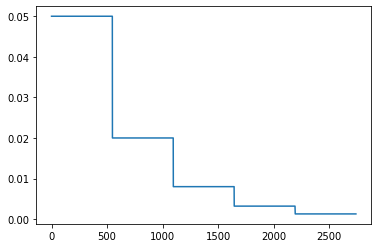

In [32]:
plt.plot(lr_find_lr)

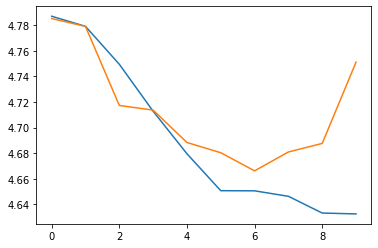

In [33]:
plt.plot(losses)

In [40]:
labels

tensor([110,  39, 106,  34, 100,  15,  38,  94,  52,  64,  29,  77,  28,  65,  16, 108])

In [56]:
a = [1, 2, 1, 3, 5, 1, 0]
b = [1, 2, 1, 3, 5, 1, 0]
a = torch.from_numpy(np.array(a))
b = torch.from_numpy(np.array(b))
print(b)
a.eq(b).sum()

tensor([1, 2, 1, 3, 5, 1, 0])


tensor(7)

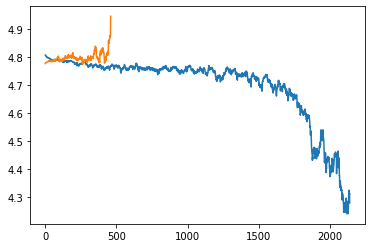

In [33]:
plt.plot(losses)
plt.plot(val_losses)

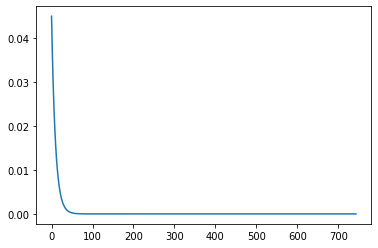

In [342]:
plt.plot(lr_find_lr)

In [24]:
network

Network(
  (conv1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=120, bias=True)
)

In [25]:
torch.save(network, "model_exec.pt")

/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [510]:
preds_files = []
labels_files = []
for batch in test_data:
    images, labels = batch
    preds = network(images)
    _, out = torch.max(preds, 1)
    print(len(out ))
    preds_files.append(out)
    labels_files.append(labels.data)

32
32
32
32
32
32
32
32


In [511]:
i = 4
print(preds_files[i])
print(labels_files[i])

tensor([102,   2, 102,   2,   2,   2,   2,   2,   2,   2,   2,   2, 102,   2,   2,   2,   2,   2,   2,   2,   2,   2,
          2,   2, 102,   2, 102,   2,   2,   2, 102,   2])
tensor([116,  72,  72,  74,  82,   1,  29,  26,  44,  47,  20,  81,  34,  36, 105,  95,  43,  57,  59,  82,  26,  52,
        107,   9, 109,  33,  73, 113,  85, 115, 111,  69])


In [512]:
sums = 0
pre = 0
for i in range(len(preds_files)):
    sums += torch.sum(preds_files[i] == labels_files[i]).item()
    pre += precision_score(np.array(preds_files[i]), np.array(labels_files[i]), average = 'macro')

print(sums)
print(sums/len(test_data.dataset))
print(pre/49)

2
0.0078125
0.0014325927415301096


## Multiple Parameter combination

In [16]:
import redis
import tensorboard
import torch.optim as optim
#import redis
import setproctitle

In [17]:
def parameter_run(config):
    
    train_data = mini_train_loader
    validation_data = mini_validation_loader
    test_data = mini_test_loader
    #step_size = config["step_size"]
    step_size = 2*len(train_data)

    for g in optimizer.param_groups:
        g['lr'] == 0.01

    max_lr = 0.2
    min_lr = 0.1
    clr = cyclical_lr(step_size, min_lr, max_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
    k = 0


    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    total_correct = 0

    losses = []
    val_losses = []
    lr_find_lr = []

    itera = 0

    smoothing = 0.05
    
    optimizer = torch.optim.SGD(network.parameters(), lr=config["lr"])
    
    clr = cyclical_lr(step_size, min_lr, max_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

    for epoch in range(15):
        for phase in ['train', 'val']:

            running_loss = 0.0
            running_corrects = 0
            total_loss = 0
            i = 0

            if phase == 'train':
                network.train()
                batch_data = train_data
            else: 
                network.eval()
                batch_data = validation_data

            for batch in batch_data:  # Get Batch

                with torch.set_grad_enabled(phase == 'train'):
                    images, labels = batch
                    #print(images.shape)
                    images = images
                    labels = labels
                    preds = network(images)

                    loss = criterion(preds, labels.long())  # Calculate Loss

                    optimizer.zero_grad()

                    running_loss += loss.item()
                    running_corrects += get_num_correct(preds, labels)
                    i+= 1
                    if phase == 'train':
                        loss.backward()  # Calculate Gradients
                        optimizer.step()  # Update Weights


                if phase == "train":
                    if itera==0:
                        losses.append(loss)
                    else:
                        loss = smoothing  * loss + (1 - smoothing) * losses[-1]
                        losses.append(loss)
                    itera += 1
                else : 
                    if itera==0:
                        val_losses.append(loss)
                    else:
                        loss = smoothing  * loss + (1 - smoothing) * val_losses[-1]
                        val_losses.append(loss)
                    itera += 1


                if phase == 'train':
                    scheduler.step()
                   # if iter == 20 :
                   #     for g in optimizer.param_groups:
                    #        g['lr'] = 0.001

                    if itera % (step_size*2) == 0 : 
                        #max_lr = max_lr * 0.8
                        max_lr = max_lr * np.exp(-1*(0.15 + ((1/10)*k)))
                        min_lr = min_lr * 0.9
                        k += 1
                        clr = cyclical_lr(step_size, min_lr, max_lr)
                        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
                    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
                    lr_find_lr.append(lr_step)

                    #if iter % 10 == 0 : print(iter, " : ", lr_step)
            epoch_loss = running_loss / len(batch_data.dataset)
            epoch_acc = running_corrects / len(batch_data.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}%'.format(
            phase, epoch_loss*100, epoch_acc*100))

        total_loss += loss.item()
        tune.track.log(mean_accuracy=epoch_acc)
    #return network, loss, val_loss, lr_find_lr

In [ ]:
param_values = {
    "batch_size": ,
    "max_lr": ,
    "step_size": ,
}

In [47]:
all_params_loss = []
for batch_size, max_lr, step_size in product(*param_values): 

    print(f' batch_size={batch_size} lr={max_lr} step_size={step_size}')
    comment = f' batch_size={batch_size} lr={max_lr} step_size={step_size}'
    network = Network()

    start_lr = 0.5
    optimizer = torch.optim.SGD(network.parameters(), start_lr)
    for g in optimizer.param_groups:
        g['lr'] == 0.01

    min_lr = 0.01
    clr = cyclical_lr(step_size, min_lr, max_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

    #train_loader = torch.utils.data.DataLoader(labeled_data,
    #                                           batch_size=batch_size,
    #                                           num_workers=0,
    #                                           shuffle=True)


    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    total_correct = 0

    lr_find_loss = []
    lr_find_lr = []

    iter = 0

    smoothing = 0.05

    for epoch in range(20):

        total_loss = 0
        total_correct = 0

        for batch in mini_train_loader:  # Get Batch
            images, labels = batch
            #labels = labels - 1
            preds = network(images)  # Pass Batch
            #print(labels)
            loss = F.cross_entropy(preds, labels.long())  # Calculate Loss

            optimizer.zero_grad()
            loss.backward()  # Calculate Gradients
            optimizer.step()  # Update Weights

            scheduler.step()
           # if iter == 20 :
           #     for g in optimizer.param_groups:
            #        g['lr'] = 0.001

            if iter % (step_size*2) == 0 : 
                max_lr = max_lr * 0.8
                clr = cyclical_lr(step_size, min_lr, max_lr)
                scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
            lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
            lr_find_lr.append(lr_step)

            if iter==0:
              lr_find_loss.append(loss)
            else:
              loss = smoothing  * loss + (1 - smoothing) * lr_find_loss[-1]
              lr_find_loss.append(loss)

            iter += 1
            #if iter % 10 == 0 : print(iter, " : ", lr_step)

            total_loss += loss.item()
            total_correct += get_num_correct(preds, labels)

        print("epoch", epoch, "average batch correct:", total_correct/32, "average batch loss:", total_loss/32)
        print('Loss: {:.4f}'.format(
                loss))
    mean = [] 
    for items in lr_find_loss:
        mean.append(items.item())
    mean = np.mean(mean)
    argmin = np.argmin(mean)
    
    print("mean loss value : ", mean)
    #print("lowest loss value : ", mean[argmin])
    print()

    all_params_loss.append([comment,lr_find_loss, lr_find_lr])

 batch_size=30 lr=0.5 step_size=32.0
epoch 0 average batch correct: 0.5625 average batch loss: 9.576214402914047
Loss: 4.7861
epoch 1 average batch correct: 0.75 average batch loss: 9.565335765480995
Loss: 4.7824
epoch 2 average batch correct: 0.96875 average batch loss: 9.559900403022766
Loss: 4.7735
epoch 3 average batch correct: 1.09375 average batch loss: 9.546399846673012
Loss: 4.7713
epoch 4 average batch correct: 1.09375 average batch loss: 9.530879631638527
Loss: 4.7704
epoch 5 average batch correct: 1.09375 average batch loss: 9.520824030041695
Loss: 4.7673
epoch 6 average batch correct: 1.09375 average batch loss: 9.513877376914024
Loss: 4.7570
epoch 7 average batch correct: 1.09375 average batch loss: 9.493736520409584
Loss: 4.7564
epoch 8 average batch correct: 1.09375 average batch loss: 9.482615202665329
Loss: 4.7464
epoch 9 average batch correct: 1.09375 average batch loss: 9.462587863206863
Loss: 4.7232
epoch 10 average batch correct: 1.125 average batch loss: 9.4144642

epoch 8 average batch correct: 1.09375 average batch loss: 9.556550964713097
Loss: 4.7784
epoch 9 average batch correct: 1.09375 average batch loss: 9.554122164845467
Loss: 4.7790
epoch 10 average batch correct: 1.09375 average batch loss: 9.555656552314758
Loss: 4.7743
epoch 11 average batch correct: 1.09375 average batch loss: 9.55266247689724
Loss: 4.7722
epoch 12 average batch correct: 1.09375 average batch loss: 9.54817858338356
Loss: 4.7753
epoch 13 average batch correct: 1.09375 average batch loss: 9.54866375029087
Loss: 4.7752
epoch 14 average batch correct: 1.09375 average batch loss: 9.547143936157227
Loss: 4.7752
epoch 15 average batch correct: 1.09375 average batch loss: 9.547129824757576
Loss: 4.7729
epoch 16 average batch correct: 1.09375 average batch loss: 9.54554831981659
Loss: 4.7708
epoch 17 average batch correct: 1.09375 average batch loss: 9.542191952466965
Loss: 4.7718
epoch 18 average batch correct: 1.09375 average batch loss: 9.542726248502731
Loss: 4.7693
epoch

epoch 16 average batch correct: 0.8125 average batch loss: 9.537625148892403
Loss: 4.7673
epoch 17 average batch correct: 1.15625 average batch loss: 9.526243224740028
Loss: 4.7644
epoch 18 average batch correct: 1.09375 average batch loss: 9.519941508769989
Loss: 4.7599
epoch 19 average batch correct: 1.09375 average batch loss: 9.516550302505493
Loss: 4.7533
mean loss value :  4.779206177964807

 batch_size=100 lr=0.5 step_size=32.0
epoch 0 average batch correct: 0.5 average batch loss: 9.579501360654831
Loss: 4.7905
epoch 1 average batch correct: 0.875 average batch loss: 9.571541503071785
Loss: 4.7840
epoch 2 average batch correct: 1.09375 average batch loss: 9.558522671461105
Loss: 4.7809
epoch 3 average batch correct: 1.09375 average batch loss: 9.54486545920372
Loss: 4.7724
epoch 4 average batch correct: 1.09375 average batch loss: 9.531980857253075
Loss: 4.7627
epoch 5 average batch correct: 1.09375 average batch loss: 9.517886638641357
Loss: 4.7588
epoch 6 average batch correc

epoch 4 average batch correct: 0.96875 average batch loss: 9.566061958670616
Loss: 4.7816
epoch 5 average batch correct: 0.96875 average batch loss: 9.562244221568108
Loss: 4.7820
epoch 6 average batch correct: 0.96875 average batch loss: 9.561138167977333
Loss: 4.7798
epoch 7 average batch correct: 0.96875 average batch loss: 9.556953206658363
Loss: 4.7789
epoch 8 average batch correct: 0.96875 average batch loss: 9.554257422685623
Loss: 4.7752
epoch 9 average batch correct: 0.96875 average batch loss: 9.546759501099586
Loss: 4.7722
epoch 10 average batch correct: 0.9375 average batch loss: 9.539032772183418
Loss: 4.7669
epoch 11 average batch correct: 0.96875 average batch loss: 9.524817526340485
Loss: 4.7701
epoch 12 average batch correct: 1.0 average batch loss: 9.52089238166809
Loss: 4.7600
epoch 13 average batch correct: 0.90625 average batch loss: 9.510946527123451
Loss: 4.7591
epoch 14 average batch correct: 1.0625 average batch loss: 9.50103560090065
Loss: 4.7562
epoch 15 aver

epoch 13 average batch correct: 1.09375 average batch loss: 9.561315476894379
Loss: 4.7802
epoch 14 average batch correct: 1.09375 average batch loss: 9.560454964637756
Loss: 4.7784
epoch 15 average batch correct: 1.09375 average batch loss: 9.558356136083603
Loss: 4.7766
epoch 16 average batch correct: 1.09375 average batch loss: 9.554296091198921
Loss: 4.7780
epoch 17 average batch correct: 1.09375 average batch loss: 9.55393123626709
Loss: 4.7769
epoch 18 average batch correct: 1.09375 average batch loss: 9.553075566887856
Loss: 4.7750
epoch 19 average batch correct: 1.09375 average batch loss: 9.549865484237671
Loss: 4.7759
mean loss value :  4.7827028013765815

 batch_size=500 lr=0.5 step_size=32.0
epoch 0 average batch correct: 0.5 average batch loss: 9.57145181298256
Loss: 4.7856
epoch 1 average batch correct: 1.09375 average batch loss: 9.565254181623459
Loss: 4.7809
epoch 2 average batch correct: 1.09375 average batch loss: 9.556451499462128
Loss: 4.7773
epoch 3 average batch 

epoch 0 average batch correct: 0.59375 average batch loss: 9.578491374850273
Loss: 4.7888
epoch 1 average batch correct: 0.65625 average batch loss: 9.574175968766212
Loss: 4.7872
epoch 2 average batch correct: 0.875 average batch loss: 9.572065502405167
Loss: 4.7847
epoch 3 average batch correct: 0.6875 average batch loss: 9.569051757454872
Loss: 4.7832
epoch 4 average batch correct: 0.84375 average batch loss: 9.565545096993446
Loss: 4.7837
epoch 5 average batch correct: 0.6875 average batch loss: 9.564953073859215
Loss: 4.7813
epoch 6 average batch correct: 0.8125 average batch loss: 9.561498373746872
Loss: 4.7808
epoch 7 average batch correct: 0.90625 average batch loss: 9.55961936712265
Loss: 4.7792
epoch 8 average batch correct: 0.90625 average batch loss: 9.556756034493446
Loss: 4.7776
epoch 9 average batch correct: 0.90625 average batch loss: 9.553084328770638
Loss: 4.7757
epoch 10 average batch correct: 0.96875 average batch loss: 9.54841923713684
Loss: 4.7736
epoch 11 average

epoch 8 average batch correct: 0.875 average batch loss: 9.568043410778046
Loss: 4.7851
epoch 9 average batch correct: 0.875 average batch loss: 9.567436531186104
Loss: 4.7843
epoch 10 average batch correct: 0.875 average batch loss: 9.565996780991554
Loss: 4.7830
epoch 11 average batch correct: 0.875 average batch loss: 9.565231025218964
Loss: 4.7808
epoch 12 average batch correct: 0.875 average batch loss: 9.562339827418327
Loss: 4.7820
epoch 13 average batch correct: 0.875 average batch loss: 9.563148811459541
Loss: 4.7802
epoch 14 average batch correct: 0.875 average batch loss: 9.560245931148529
Loss: 4.7811
epoch 15 average batch correct: 0.875 average batch loss: 9.560399562120438
Loss: 4.7789
epoch 16 average batch correct: 0.875 average batch loss: 9.556991666555405
Loss: 4.7793
epoch 17 average batch correct: 0.875 average batch loss: 9.557328000664711
Loss: 4.7765
epoch 18 average batch correct: 0.875 average batch loss: 9.552667528390884
Loss: 4.7796
epoch 19 average batch 

193.7097359140714  minutes.


In [26]:
for safe in all_params_loss:
    #print(safe[1])
    
    print(torch.mean(torch.stack(safe[1])).item())
    print(safe[2])

4.7842912673950195
[0.0005, 0.0006423357664233596, 0.000784671532846715, 0.0009270072992700747, 0.00106934306569343, 0.0012116788321167899, 0.0013540145985401451, 0.0014963503649635048, 0.00163868613138686, 0.0017810218978102197, 0.001923357664233575, 0.002065693430656935, 0.0022080291970802903, 0.00235036496350365, 0.0024927007299270095, 0.0026350364963503648, 0.002777372262773725, 0.00291970802919708, 0.0030620437956204397, 0.0032043795620437946, 0.0033467153284671546, 0.0034890510948905095, 0.0036313868613138695, 0.0037737226277372244, 0.003916058394160584, 0.0040583941605839445, 0.004200729927007299, 0.004343065693430659, 0.004485401459854014, 0.004627737226277374, 0.004770072992700729, 0.004912408759124089, 0.005054744525547444, 0.005197080291970804, 0.00533941605839416, 0.005481751824817519, 0.005624087591240879, 0.005766423357664234, 0.00590875912408759, 0.006051094890510949, 0.006193430656934309, 0.0063357664233576645, 0.006478102189781024, 0.006620437956204379, 0.0067627737226

In [1]:
fig = plt.figure(figsize=(15, 15))

for i in range(len(all_params_loss)):
    j = i+1
    ax = fig.add_subplot(9, 3, j)
    plt.tight_layout()
    plt.title(all_params_loss[i][0])
    plt.plot(all_params_loss[i][1])
    #plt.plot(all_params_loss[i][2])


    plt.axhline(y=torch.mean(torch.stack(all_params_loss[i][1])).item(), color='r', linestyle='-')
    axes = plt.gca()
    #axes.set_ylim([1.5,5])

    #plt.axis('tight')

NameError: name 'plt' is not defined

# Transfer Learning

In [9]:
layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
blocks = ['conv1', 'bn1', 'conv2', 'bn2']

def resnet_weight_find(model):
    weight_list = []
    for layer in layers:
        att = getattr(model,layer)
        if 'layer' in layer:
            for lay in att: 
                for block in blocks:
                    att_block = getattr(lay, block)
                    weight_list.append(att_block.weight)
        else : weight_list.append(att.weight)
    return weight_list

def resnet_weight_compare(list_before, list_after):
    flag = True
    changed = []
    unchanged = []
    for i in range(len(list_before)):
        if (np.array_equal(list_before[i][1], list_after[i][1]) == False):
            #print(list_before[i][0] , " has changed")
            changed.append(list_before[i][0])
        else :
            unchanged.append(list_before[i][0])
            #print(list_before[i][0], "has not changed")
    print("all changed : ", changed)
    print("#"*10)
    print("all unchanged : ", unchanged)
        
def model_weight(model):
    list_mem = []
    for name, tens in list(model.state_dict().items()):
        if "weight" in name:
            list_mem.append((name, np.array(tens).copy()))
    return list_mem

In [17]:
np.array_equal(model_weight(model_ft)[0], model_weight(model_ft)[1])

NameError: name 'model_ft' is not defined

In [11]:
def train_network(network, train_data, validation_data, optimizer, criterion, losses, f1_scores, acc_scores, lr_find_lr, total_loss = 0, total_correct = 0):

    best_network_wts = copy.deepcopy(network.state_dict())
    best_acc = 0.0

    i_train = 0
    i_val = 0
    loss_train, loss_valid = [], []
    f1_train, f1_valid = [], []
    acc_train, acc_valid = [], []
    
    total_f1_train, total_f1_valid = 0, 0
    total_acc_train = 0
    total_acc_valid = 0
    total_loss_train, total_loss_valid = 0, 0
    
    #w01 = list(network.state_dict().items())[6][1][0][0][0][0].item()
    #w02 = list(network.state_dict().items())[-2][1][0][0].item()
    #weight_list_0 = network_weight(model)
    #list0 = weight_list_0[:].copy()
    #print("after step update for w0", weight_list_0[2][0][0][0][0], weight_list_0[-1][0][0], list0[2][0][0][0][0], list0[-1][0][0])
    #if(epoch > 1):
        #print("after step update for w1", weight_list_1[2][0][0][0][0], weight_list_1[-1][0][0], list1[2][0][0][0][0], list1[-1][0][0])
        #print(list(model.state_dict().items())[6][1][0][0][0][0], list(model.state_dict().items())[-2][1][0][0])       
        #resnet_weight_compare(weight_list_1, weight_list_0)
    #print(weight_list_0[2][0], weight_list_0[-1][0])
    #print(list0[2][0], list0[-1][0])
    #print(w01, w02)
    #Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        
        running_loss = 0.0
        running_corrects = 0
        
        if phase == 'train':
            network.train()
            batch_data = train_data
        else: 
            network.eval()
            batch_data = validation_data
        
        for batch in batch_data:  # Get Batch
            # zero the parameter gradients
            optimizer.zero_grad()
            temp, index = batch
            inputs, labels = temp

            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.cuda()

            labels = labels.squeeze_()
            labels = labels.cuda()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = network(inputs)
                _, preds = torch.max(outputs, 1)
                #labels = labels - 1

                loss = criterion(outputs, labels.long())

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            colis = preds.long()
            #print("preds are : ", colis.tolist())
            #print("true are : ", labels.tolist())
            result = classification_report(labels.tolist(), colis.tolist(), digits = 120, output_dict = True)
            #print("result : ", result["weighted avg"])
            #report_avg = report(torch.Tensor(labels.tolist()), colis, phase == 'val') 
            report_avg = result["weighted avg"]
            # statistics
            if phase == "train":
              if len(loss_train)==0:
                  loss_train.append(loss)
                  i_train += 1
                  f1_train.append(report_avg["f1-score"])
                  acc_train.append(report_avg["precision"])
              else:
                  loss = smoothing  * loss + (1 - smoothing) * loss_train[-1]
                  loss_train.append(loss)
                  i_train += 1
                  
                  #f1_score = smoothing  * f1_score + (1 - smoothing) * f1_train[-1]
                  f1_train.append(report_avg["f1-score"])
                  
                  #acc_sco = smoothing  * acc_sco + (1 - smoothing) * acc_train[-1]
                  acc_train.append(report_avg["precision"])
              total_f1_train += report_avg["f1-score"]
              total_acc_train += report_avg["precision"]
              total_loss_train += loss
            else : 
              if len(loss_valid)==0:
                  loss_valid.append(loss)
                  i_val += 1
                  f1_valid.append(report_avg["f1-score"])
                  acc_valid.append(report_avg["precision"])
              else:
                  loss = smoothing  * loss + (1 - smoothing) * loss_valid[-1]
                  loss_valid.append(loss)
                  i_val += 1
                  
                  #f1_score = smoothing  * f1_score + (1 - smoothing) * f1_valid[-1]
                  f1_valid.append(report_avg["f1-score"])
                  
                  #acc_sco = smoothing  * acc_sco + (1 - smoothing) * acc_valid[-1]
                  acc_valid.append(report_avg["precision"])
              total_f1_valid += report_avg["f1-score"]
              total_acc_valid += report_avg["precision"]
              total_loss_valid += loss
            lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
            lr_find_lr.append(lr_step)
            #print("lr inside : ", lr_step)

          #if phase == 'train':
              #scheduler.step()

              #if itera % (step_size*2) == 0 : 
              #    max_lr = max_lr * np.exp(-1*(0.15 + ((1/10)*k)))
              #    min_lr = min_lr * 0.9
              #    k += 1
              #    clr = cyclical_lr(step_size, min_lr, max_lr)
              #    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
              #lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
              #lr_find_lr.append(lr_step)
              
              #if iter % 10 == 0 : print(iter, " : ", lr_step)
    epoch_loss_train = total_loss_train / len(train_data)
    epoch_acc_train = total_acc_train / len(train_data)
    epoch_f1_train = total_f1_train/ len(train_data)

    epoch_loss_valid = total_loss_valid / len(validation_data)
    epoch_acc_valid = total_acc_valid / len(validation_data)
    epoch_f1_valid = total_f1_valid/ len(validation_data)

    print('train Loss: {:.4f} Acc: {:.4f}% F1 Score = {:.4f}'.format(
    epoch_loss_train, epoch_acc_train, epoch_f1_train))
    print('valid Loss: {:.4f} Acc: {:.4f}% F1 Score = {:.4f}'.format(
    epoch_loss_valid, epoch_acc_valid, epoch_f1_valid))
    replace = []
    for items in loss_valid:
        replace.append(items.item())
    loss_valid = replace
    replace = []
    for items in loss_train:
        replace.append(items.item())
    loss_train = replace

    losses.append([np.mean(loss_train), np.mean(loss_valid)])
    f1_scores.append([f1_train, f1_valid])
    acc_scores.append([acc_train, acc_valid])
    return network, losses, f1_scores, acc_scores, lr_find_lr

In [ ]:
%%time
from torchvision import models 

gammas = [0.2, 0.1, 0.05]
lrs = [0.01, 0.005]
batches = [128, 64, 32]
memories_arr = []

itera = 1
for gamma_val in gammas:
  for lr in lrs:
    model_ft = models.resnet50(pretrained=True)

    for param in model_ft.parameters():
        param.requires_grad = False
    
    num_ftrs = model_ft.fc.in_features
        
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, 120)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model_ft = model_ft.to("cuda:0")

    criterion = nn.CrossEntropyLoss()

    step_size_val = 8*len(dataloader_train)

    smoothing = 0.05
    #for g in optimizer.param_groups:
    #    g['lr'] == 0.001

  
    start_lr = 0.1
    epoch_len = 15
    optimizer = torch.optim.SGD(model_ft.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.floor(epoch_len/5), gamma=gamma_val)

    k = 0

    criterion = nn.CrossEntropyLoss().cuda()

    total_loss = 0
    total_correct = 0

    losses = []
    f1_scores = []
    acc_scores = []
    lr_find_lr = []

    #max_lr = 0.2
    #min_lr = 0.1

    smoothing = 0.05

    for epoch in range(epoch_len):
      print("epoch : ", epoch, "model association # : ", itera, "/", len(gammas)*len(lrs), "values : ", gamma_val, lr)
      model_ft,losses, f1_scores, acc_scores, lr_find_lr = train_network(model_ft, dataloader_train, dataloader_valid, optimizer, criterion, losses, f1_scores, acc_scores, lr_find_lr)
      scheduler.step()
      print("lr is : ", optimizer.state_dict()["param_groups"][0]["lr"])
      print("__"*10, '\n')
    itera += 1
    memories_arr.append([losses, f1_scores, acc_scores, lr_find_lr, itera])
    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/martinvielvoye/.cache/torch/checkpoints/resnet50-19c8e357.pth
 59%|█████▉    | 58.0M/97.8M [07:32<06:15, 111kB/s] 

In [24]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './Images'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

FileNotFoundError: [Errno 2] No such file or directory: './Images/train'

In [25]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

for param in model_ft.parameters():
    param.requires_grad = False
    
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 120)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer_ft, [exp_lr_scheduler])

step_size = len(mini_train_loader)

start_lr = 0.5
optimizer = torch.optim.SGD(model_ft.parameters(), start_lr)
#for g in optimizer.param_groups:
#    g['lr'] == 0.001
    
max_lr = 0.5
min_lr = 0.01
clr = cyclical_lr(step_size, min_lr, max_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

##########################################################################################################
##########################################################################################################

In [412]:
model_ft, loss_data, lr_data = train_model(model_ft, criterion, optimizer, scheduler, mini_train_loader,
                       num_epochs=15)

64
Epoch 0/14
----------
step 0


KeyboardInterrupt: 

0.09299726486206054  minutes.


In [387]:
print(model_weight(model_ft)[2][0])
w01 = list(model_ft.state_dict().items())[0][1][3]
w02 = list(model_ft.state_dict().items())[-2][1][0][0].item()
print(w01)
#weight_list_0[2][0], weight_list_0[-1][0]

0.2303069
tensor([[[-8.5968e-03, -1.7728e-02, -1.0580e-02, -4.7519e-03,  6.4875e-03, -1.1089e-02, -9.4902e-03],
         [-2.8250e-02, -2.8228e-02, -3.6105e-03, -2.2669e-02, -7.2894e-02, -6.4143e-02, -1.7437e-02],
         [-3.4971e-02, -1.8505e-02, -2.5646e-02, -8.8647e-02, -1.4014e-01, -1.4543e-01, -3.3192e-02],
         [-2.7498e-02, -5.1640e-03, -7.5960e-03, -4.0925e-02, -7.5165e-02, -1.0266e-01, -4.6687e-03],
         [-3.7503e-02, -1.1092e-02, -9.9858e-03, -2.5855e-03, -2.5031e-02, -5.8500e-02,  6.7753e-03],
         [-8.3105e-03,  1.9493e-02,  4.3130e-03,  2.1649e-02,  1.8912e-02, -8.6313e-03,  1.0472e-02],
         [-1.7221e-02,  8.5650e-05, -2.1977e-02, -5.8163e-03, -1.7921e-04, -1.6232e-02, -4.1312e-03]],

        [[ 2.3620e-02,  3.4319e-03,  1.0774e-02,  1.6109e-02,  2.6981e-02,  1.5334e-02,  2.0540e-02],
         [ 3.2062e-02,  2.0421e-02,  2.6771e-02, -9.9913e-03, -7.1342e-02, -4.4625e-02,  2.7517e-02],
         [ 1.7748e-02,  2.6550e-02, -8.9960e-03, -1.0123e-01, -1.6956e

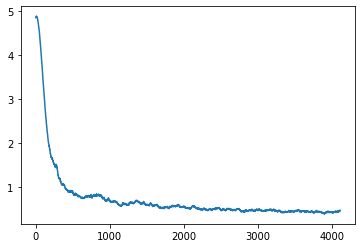

In [51]:
plt.plot(loss_data)

In [78]:
preds_files = []
labels_files = []
for batch in test_loader:
    images, labels = batch
    preds = network(images)
    _, out = torch.max(preds, 1)
    print(len(out ))
    preds_files.append(out)
    labels_files.append(labels.data)

64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
15


0.5421756625175476  minutes.


In [74]:
it = 3
print(preds_files[it])
print(labels_files[it])

tensor([ 44,  50,   8,   1,  88,  18,  65,  23,  79,  65,  49,  65,  27, 101,  21,  62])
tensor([ 90,  57,   8,  66,  16,  44,  30,  17, 109, 112,  75,  69,  99,  87,  25,  70])


In [ ]:
network.numel

In [52]:
labels_files

[tensor([ 65,  16,   9,  89,  75,  85,  67,  19,  85,  33, 108,  72,  72,  55,  91,  37,  29,  31,  97,  93,  30,  45,
          23,  40,   7, 101,  25,   5,  49, 102,  84,  81,  34,  93,  17,  72,  15,  90,  79,  66, 102,  32,  83,   4,
          74,  43,  38,  78,  15,  16,  70,  63,  -1,  88, 107,  39,  58,  18,  74,  37, 106,  92,  98,  87]),
 tensor([ 62, 118, 110,  -1,   3,  47,  86,  73, 112,  65,  25,  57,  22,  84,  56,  39,  14,   1,  78,  94,  55, 102,
          13,  83,   9,  73,   3,  58,   6,  29,  88, 108,  81,   5,  15, 110,  14, 104,  16,  55, 112,  45,  71,  19,
         104,  25,  29,  22,  76,  21,  65,  38,  20,  41,  60,  24,  42,   9,   2,  80,  65,  89, 108,   8]),
 tensor([112,  53, 100,  49,   7, 103, 115,  96,  96,  63,  27,   4,  24,  28, 117,  54, 114, 105,  96, 113,  73,  66,
          86,  48,  56,   8, 100,  83,  65,  99,  70,   8,   3,  40,  36,   4,  38,  64,  45,  71,  34,  23,  70,  33,
          61,  27,  41, 113, 100,  44,   8, 112,  -1,  86,  11, 

In [79]:
result_races = np.zeros(120)
for lists in labels_files:
    for label in lists: 
        result_races[label] += 1
result_races

array([18., 21., 35., 24., 35., 23., 30., 25., 28., 31., 21., 33., 36.,
       39., 29., 26., 19., 21., 18., 24., 31., 28., 24., 40., 25., 29.,
       31., 26., 24., 19., 39., 19., 32., 26., 25., 14., 25., 23., 28.,
       31., 28., 25., 32., 24., 33., 18., 17., 20., 23., 28., 31., 17.,
       31., 18., 22., 25., 21., 24., 35., 22., 24., 27., 25., 24., 18.,
       23., 20., 24., 23., 21., 18., 22., 26., 28., 24., 19., 31., 25.,
       30., 27., 29., 26., 19., 24., 24., 22., 34., 18., 28., 25., 31.,
       18., 25., 21., 21., 23., 23., 28., 31., 33., 24., 32., 31., 35.,
       32., 34., 23., 38., 30., 23., 20., 30., 22., 15., 24., 23., 25.,
       26., 24., 25.])

In [80]:
sums = 0
pre = 0
percent_races = np.zeros(120)
for i in range(len(preds_files)):
    sums += torch.sum(preds_files[i] == labels_files[i]).item()
    pre += precision_score(np.array(preds_files[i]), np.array(labels_files[i]), average = 'macro')
    for j in range(len(labels_files[i])): 
        if(labels_files[i][j] == preds_files[i][j]):
            percent_races[labels_files[i][j]] += 1

print(sums)
print(sums/len(test_loader.dataset))
print(pre/8)
print(percent_races)

66
0.021379980563654033
0.08044922244922387
[0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 3. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 3.
 0. 1. 2. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 5. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 1. 1. 1. 1. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 4.
 0. 1. 0. 0. 1. 2. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 0. 2. 1. 1. 0. 0. 1. 0. 4. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]


In [77]:
final_per_race = []
for i in range(len(result_races)):
    if(percent_races[i] != 0): final_per_race.append(percent_races[i]/result_races[i])
    else: final_per_race.append(0)
final_per_race

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.25,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.2,
 0,
 0,
 0.3333333333333333,
 0,
 0,
 0,
 0.3333333333333333,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.25,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.3333333333333333,
 0,
 0,
 0,
 0,
 0.3333333333333333,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [122]:
layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
blocks = ['conv1', 'bn1', 'conv2', 'bn2']

In [123]:
for lay in model_ft.layer1:
    print(lay.conv1)

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [180]:
weight_list = []
for layer in layers:
    att = getattr(model_ft,layer)
    if 'layer' in layer:
        for lay in att: 
            for block in blocks:
                att_block = getattr(lay, block)
                weight_list.append(att_block.weight)
    else : weight_list.append(att.weight)

weight_list

[Parameter containing:
 tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,  1.7083e-02, -1.2694e-02],
           [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01, -1.2907e-01,  3.7424e-03],
           [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,  2.5632e-01,  6.3573e-02],
           ...,
           [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01, -4.2058e-01, -2.5781e-01],
           [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,  3.9359e-01,  1.6606e-01],
           [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01, -8.2230e-02, -5.7828e-03]],
 
          [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,  6.6221e-04, -2.5743e-02],
           [ 4.5687e-02,  3.3603e-02, -1.0453e-01,  ..., -3.1253e-01, -1.6051e-01, -1.2826e-03],
           [-8.3730e-04,  9.8420e-02,  4.0210e-01,  ...,  7.0789e-01,  3.6887e-01,  1.2455e-01],
           ...,
           [-5.5926e-02, -5.2239e-03,  2.7081e-02,  ..., -4.6178e-01,

In [211]:
weight_list[2][0][0][0][0]

tensor(0.0576)

In [194]:
np.sum(np.array(preds_files[0]) == np.array(labels_files[0]))

44

In [62]:
accuracy_score(np.array(preds_files[1]), np.array(labels_files[1]))

0.78125

In [63]:
precision_score(np.array(preds_files[1]), np.array(labels_files[1]), average = 'macro')

0.6637931034482759